# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)

# The model
Let's start with the model we first saw

In [7]:
dropout_value=0.05
class Net(nn.Module):
    def __init__(self, Ghost_BN = False):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10) if Ghost_BN is False else GhostBatchNorm(num_features=10,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10) if Ghost_BN is False else GhostBatchNorm(num_features=10,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
             ReLU-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_penalty = 0):
    train_losses = []
    train_accuracy = []

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)
          # l1 regularization
      if l1_penalty:
          with torch.enable_grad():
              l1_loss=0
              for param in model.parameters():
                  l1_loss+=torch.sum(param.abs())
              loss+=l1_penalty*l1_loss  

      train_losses.append(loss)
      
      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy: {100*correct/processed:0.2f}% ')
      train_accuracy.append(100*correct/processed)
 
    return train_losses, train_accuracy

def test(model, device, test_loader):
    test_losses = []
    test_accuracy = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_accuracy


# Let's Train and test our model

In [10]:
model_versions = {1:"L1 + BN", 2:"L2 + BN", 3:"L1 + L2 + BN", 4:"GBN", 5:"L1 + GBN", 6:"L2 + GBN", 7:"L1 + L2 + GBN"}

In [11]:
print(model_versions[1])
print(model_versions[2])
print(model_versions[3])
print(model_versions[4])
print(model_versions[5])
print(model_versions[6])
print(model_versions[7])

L1 + BN
L2 + BN
L1 + L2 + BN
GBN
L1 + GBN
L2 + GBN
L1 + L2 + GBN


In [12]:
def get_regularization_params(model_version):
  if "GBN" in model_version:
    Ghost_BN = True
  else:
    Ghost_BN = False

  if "L1" in model_version:
    l1_penalty = 0.0001
  else:
    l1_penalty = 0

  if "L2" in model_version:
    l2_penalty = 1e-5
  else:
    l2_penalty = 0
  
  return l1_penalty, l2_penalty, Ghost_BN

In [13]:
EPOCHS = 25
model_history = {}
for model_number, model_version in model_versions.items():
  print(model_version)

  train_loss=[]
  train_acc=[]
  test_loss=[]
  test_acc=[]

  l1_penalty, l2_penalty, Ghost_BN = get_regularization_params(model_version)
  print(f"l1_penalty: {l1_penalty}"); print(f"l2_penalty: {l2_penalty}"); print(f"Ghost_BN: {Ghost_BN}")
  
  model = Net(Ghost_BN).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_penalty)
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss_epoch, train_accuracy_epoch = train(model, device, train_loader, optimizer, epoch,l1_penalty)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_accuracy_epoch)
    test_loss_epoch, test_accuracy_epoch = test(model, device, test_loader)
    test_loss.append(test_loss_epoch)
    test_acc.append(test_accuracy_epoch)

  model_history[model_number]={"train_loss":train_loss, "train_acc":train_acc, "test_loss":test_loss, "test_acc":test_acc}

# print(f"\nMaximum training accuracy: {train_max}\n")
# print(f"\nMaximum test accuracy: {test_max}\n")

  0%|          | 0/469 [00:00<?, ?it/s]

L1 + BN
l1_penalty: 0.0001
l2_penalty: 0
Ghost_BN: False
EPOCH: 0


Loss=0.17222227156162262 Batch_id=468 Accuracy: 86.24% : 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9753/10000 (97.53%)

EPOCH: 1


Loss=0.10319706052541733 Batch_id=468 Accuracy: 97.92% : 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.11557061225175858 Batch_id=468 Accuracy: 98.34% : 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.06547746807336807 Batch_id=468 Accuracy: 98.62% : 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.0862412303686142 Batch_id=468 Accuracy: 98.76% : 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.07162760198116302 Batch_id=468 Accuracy: 98.79% : 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.09085199981927872 Batch_id=468 Accuracy: 98.90% : 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.09440059959888458 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.08808604627847672 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.12583374977111816 Batch_id=468 Accuracy: 99.01% : 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.07350851595401764 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.06785409152507782 Batch_id=468 Accuracy: 99.07% : 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.07250238209962845 Batch_id=468 Accuracy: 98.99% : 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.09471563249826431 Batch_id=468 Accuracy: 99.05% : 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.11545483022928238 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.10135112702846527 Batch_id=468 Accuracy: 99.10% : 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.05352666974067688 Batch_id=468 Accuracy: 99.09% : 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.11503976583480835 Batch_id=468 Accuracy: 99.01% : 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)

EPOCH: 18


Loss=0.06838519871234894 Batch_id=468 Accuracy: 99.13% : 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9895/10000 (98.95%)

EPOCH: 19


Loss=0.09586089849472046 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

EPOCH: 20


Loss=0.05231166258454323 Batch_id=468 Accuracy: 99.24% : 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.10156506299972534 Batch_id=468 Accuracy: 99.12% : 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.06111643463373184 Batch_id=468 Accuracy: 99.15% : 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9894/10000 (98.94%)

EPOCH: 23


Loss=0.0877099335193634 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.07109957933425903 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9909/10000 (99.09%)

L2 + BN
l1_penalty: 0
l2_penalty: 1e-05
Ghost_BN: False
EPOCH: 0


Loss=0.09266871213912964 Batch_id=468 Accuracy: 87.38% : 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1346, Accuracy: 9629/10000 (96.29%)

EPOCH: 1


Loss=0.10623907297849655 Batch_id=468 Accuracy: 97.44% : 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.11670098453760147 Batch_id=468 Accuracy: 98.15% : 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.03576093539595604 Batch_id=468 Accuracy: 98.44% : 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.06506568938493729 Batch_id=468 Accuracy: 98.65% : 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.04008035734295845 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.028099937364459038 Batch_id=468 Accuracy: 98.93% : 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.0535535104572773 Batch_id=468 Accuracy: 98.97% : 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.035606518387794495 Batch_id=468 Accuracy: 99.03% : 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.005134080071002245 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.02137872576713562 Batch_id=468 Accuracy: 99.19% : 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.011500590480864048 Batch_id=468 Accuracy: 99.22% : 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.00482133636251092 Batch_id=468 Accuracy: 99.22% : 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.02988573908805847 Batch_id=468 Accuracy: 99.31% : 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.005324834957718849 Batch_id=468 Accuracy: 99.24% : 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.10630401223897934 Batch_id=468 Accuracy: 99.37% : 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.010570424608886242 Batch_id=468 Accuracy: 99.31% : 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.011690136045217514 Batch_id=468 Accuracy: 99.33% : 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.02650977112352848 Batch_id=468 Accuracy: 99.40% : 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.004855948034673929 Batch_id=468 Accuracy: 99.34% : 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.0058571468107402325 Batch_id=468 Accuracy: 99.42% : 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.001516304793767631 Batch_id=468 Accuracy: 99.40% : 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.0502551794052124 Batch_id=468 Accuracy: 99.47% : 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


Loss=0.02687748335301876 Batch_id=468 Accuracy: 99.43% : 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.03258637711405754 Batch_id=468 Accuracy: 99.50% : 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

L1 + L2 + BN
l1_penalty: 0.0001
l2_penalty: 1e-05
Ghost_BN: False
EPOCH: 0


Loss=0.15779325366020203 Batch_id=468 Accuracy: 87.60% : 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


Loss=0.12931214272975922 Batch_id=468 Accuracy: 97.62% : 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9843/10000 (98.43%)

EPOCH: 2


Loss=0.10786880552768707 Batch_id=468 Accuracy: 98.21% : 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.16451908648014069 Batch_id=468 Accuracy: 98.41% : 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.10167437791824341 Batch_id=468 Accuracy: 98.65% : 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.10011450946331024 Batch_id=468 Accuracy: 98.69% : 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.06864501535892487 Batch_id=468 Accuracy: 98.73% : 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.10347099602222443 Batch_id=468 Accuracy: 98.88% : 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.0946570485830307 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.11648383736610413 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.12807391583919525 Batch_id=468 Accuracy: 98.88% : 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.07244296371936798 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.1213984489440918 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.0818849429488182 Batch_id=468 Accuracy: 99.01% : 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.0651550441980362 Batch_id=468 Accuracy: 99.01% : 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.08680596947669983 Batch_id=468 Accuracy: 98.99% : 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.0772857815027237 Batch_id=468 Accuracy: 99.04% : 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.1298150271177292 Batch_id=468 Accuracy: 99.09% : 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9893/10000 (98.93%)

EPOCH: 18


Loss=0.058357611298561096 Batch_id=468 Accuracy: 99.03% : 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.06251869350671768 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9914/10000 (99.14%)

EPOCH: 20


Loss=0.05626346915960312 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9911/10000 (99.11%)

EPOCH: 21


Loss=0.12005046010017395 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9896/10000 (98.96%)

EPOCH: 22


Loss=0.0775132104754448 Batch_id=468 Accuracy: 99.12% : 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 23


Loss=0.09709368646144867 Batch_id=468 Accuracy: 99.15% : 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9907/10000 (99.07%)

EPOCH: 24


Loss=0.10097724199295044 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

GBN
l1_penalty: 0
l2_penalty: 0
Ghost_BN: True
EPOCH: 0


Loss=0.14818523824214935 Batch_id=468 Accuracy: 86.29% : 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1313, Accuracy: 9649/10000 (96.49%)

EPOCH: 1


Loss=0.1524524986743927 Batch_id=468 Accuracy: 97.26% : 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.04370507225394249 Batch_id=468 Accuracy: 97.96% : 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.05297096446156502 Batch_id=468 Accuracy: 98.30% : 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.0835181176662445 Batch_id=468 Accuracy: 98.37% : 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.08919236063957214 Batch_id=468 Accuracy: 98.49% : 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.021663539111614227 Batch_id=468 Accuracy: 98.63% : 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.12870557606220245 Batch_id=468 Accuracy: 98.72% : 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.01925334893167019 Batch_id=468 Accuracy: 98.69% : 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.020518062636256218 Batch_id=468 Accuracy: 98.85% : 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.017671626061201096 Batch_id=468 Accuracy: 98.87% : 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.04229604825377464 Batch_id=468 Accuracy: 98.92% : 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.028593746945261955 Batch_id=468 Accuracy: 98.93% : 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.04186122491955757 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.016561120748519897 Batch_id=468 Accuracy: 99.04% : 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.05017067864537239 Batch_id=468 Accuracy: 99.09% : 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.026456227526068687 Batch_id=468 Accuracy: 99.02% : 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.029905999079346657 Batch_id=468 Accuracy: 99.13% : 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

EPOCH: 18


Loss=0.1232137382030487 Batch_id=468 Accuracy: 99.06% : 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.012756753712892532 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.03627651557326317 Batch_id=468 Accuracy: 99.15% : 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.02933301217854023 Batch_id=468 Accuracy: 99.13% : 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.023743480443954468 Batch_id=468 Accuracy: 99.19% : 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.04364311695098877 Batch_id=468 Accuracy: 99.20% : 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.00912414025515318 Batch_id=468 Accuracy: 99.19% : 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

L1 + GBN
l1_penalty: 0.0001
l2_penalty: 0
Ghost_BN: True
EPOCH: 0


Loss=0.1731298416852951 Batch_id=468 Accuracy: 84.95% : 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0856, Accuracy: 9801/10000 (98.01%)

EPOCH: 1


Loss=0.1510585993528366 Batch_id=468 Accuracy: 97.23% : 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.12908852100372314 Batch_id=468 Accuracy: 97.84% : 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.12031851708889008 Batch_id=468 Accuracy: 98.11% : 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.0954425260424614 Batch_id=468 Accuracy: 98.29% : 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.08565928786993027 Batch_id=468 Accuracy: 98.50% : 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.08889750391244888 Batch_id=468 Accuracy: 98.51% : 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9880/10000 (98.80%)

EPOCH: 7


Loss=0.06706064194440842 Batch_id=468 Accuracy: 98.64% : 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.09548364579677582 Batch_id=468 Accuracy: 98.60% : 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.0958789512515068 Batch_id=468 Accuracy: 98.64% : 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.0865921676158905 Batch_id=468 Accuracy: 98.64% : 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.17720472812652588 Batch_id=468 Accuracy: 98.71% : 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.17769113183021545 Batch_id=468 Accuracy: 98.77% : 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


Loss=0.1411953568458557 Batch_id=468 Accuracy: 98.76% : 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.06981121748685837 Batch_id=468 Accuracy: 98.78% : 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.08023924380540848 Batch_id=468 Accuracy: 98.87% : 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.10281196236610413 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.08586582541465759 Batch_id=468 Accuracy: 98.88% : 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.08254842460155487 Batch_id=468 Accuracy: 98.92% : 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

EPOCH: 19


Loss=0.1423168182373047 Batch_id=468 Accuracy: 98.89% : 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9897/10000 (98.97%)

EPOCH: 20


Loss=0.120425745844841 Batch_id=468 Accuracy: 98.89% : 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.12032163888216019 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)

EPOCH: 22


Loss=0.11797267198562622 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 23


Loss=0.06603649258613586 Batch_id=468 Accuracy: 98.85% : 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9910/10000 (99.10%)

EPOCH: 24


Loss=0.05805347114801407 Batch_id=468 Accuracy: 98.89% : 100%|██████████| 469/469 [00:15<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

L2 + GBN
l1_penalty: 0
l2_penalty: 1e-05
Ghost_BN: True
EPOCH: 0


Loss=0.10669330507516861 Batch_id=468 Accuracy: 86.50% : 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.06222323700785637 Batch_id=468 Accuracy: 97.33% : 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.04709195718169212 Batch_id=468 Accuracy: 98.03% : 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.02793719619512558 Batch_id=468 Accuracy: 98.25% : 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.026375338435173035 Batch_id=468 Accuracy: 98.52% : 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.04732486233115196 Batch_id=468 Accuracy: 98.52% : 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.014378397725522518 Batch_id=468 Accuracy: 98.71% : 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.00946903694421053 Batch_id=468 Accuracy: 98.74% : 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.055222105234861374 Batch_id=468 Accuracy: 98.85% : 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.051904961466789246 Batch_id=468 Accuracy: 98.88% : 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.04705154895782471 Batch_id=468 Accuracy: 98.97% : 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.04000232741236687 Batch_id=468 Accuracy: 98.97% : 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.024292834103107452 Batch_id=468 Accuracy: 99.01% : 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.03658721596002579 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.018134839832782745 Batch_id=468 Accuracy: 99.12% : 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.09752316027879715 Batch_id=468 Accuracy: 99.10% : 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.027854224666953087 Batch_id=468 Accuracy: 99.10% : 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.04593648016452789 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.009921187534928322 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.002239485736936331 Batch_id=468 Accuracy: 99.22% : 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.011383414268493652 Batch_id=468 Accuracy: 99.18% : 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.01524313259869814 Batch_id=468 Accuracy: 99.20% : 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH: 22


Loss=0.00405209232121706 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.025036022067070007 Batch_id=468 Accuracy: 99.25% : 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.02590925432741642 Batch_id=468 Accuracy: 99.28% : 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9923/10000 (99.23%)

L1 + L2 + GBN
l1_penalty: 0.0001
l2_penalty: 1e-05
Ghost_BN: True
EPOCH: 0


Loss=0.1783888190984726 Batch_id=468 Accuracy: 86.08% : 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


Loss=0.1312555968761444 Batch_id=468 Accuracy: 97.56% : 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.14806830883026123 Batch_id=468 Accuracy: 98.06% : 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.1317383348941803 Batch_id=468 Accuracy: 98.33% : 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.1542816162109375 Batch_id=468 Accuracy: 98.39% : 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.18312577903270721 Batch_id=468 Accuracy: 98.47% : 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.1466362625360489 Batch_id=468 Accuracy: 98.58% : 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.07930676639080048 Batch_id=468 Accuracy: 98.61% : 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.2226715385913849 Batch_id=468 Accuracy: 98.67% : 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.087704136967659 Batch_id=468 Accuracy: 98.69% : 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.08705418556928635 Batch_id=468 Accuracy: 98.80% : 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.1436043530702591 Batch_id=468 Accuracy: 98.77% : 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.13065221905708313 Batch_id=468 Accuracy: 98.79% : 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)

EPOCH: 13


Loss=0.10619092732667923 Batch_id=468 Accuracy: 98.87% : 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.07783210277557373 Batch_id=468 Accuracy: 98.78% : 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.06755569577217102 Batch_id=468 Accuracy: 98.91% : 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 16


Loss=0.09613439440727234 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.07270895689725876 Batch_id=468 Accuracy: 98.92% : 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 18


Loss=0.07932707667350769 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

EPOCH: 19


Loss=0.07027626037597656 Batch_id=468 Accuracy: 98.90% : 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.11670155823230743 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.07640662789344788 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 22


Loss=0.11187157779932022 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.09848593175411224 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9910/10000 (99.10%)

EPOCH: 24


Loss=0.06846177577972412 Batch_id=468 Accuracy: 98.92% : 100%|██████████| 469/469 [00:15<00:00, 30.73it/s]



Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99.15%)



# Plotting Results

Text(0, 0.5, 'Train Loss')

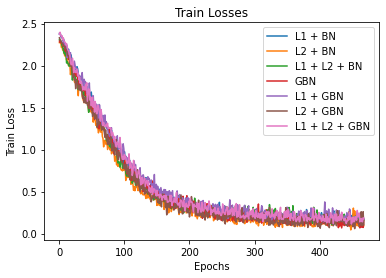

In [17]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["train_loss"][0],label=model_version)
  leg = ax.legend()
  
plt.title('Train Losses')
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

Text(0, 0.5, 'Validation Loss')

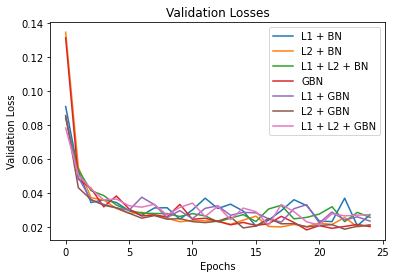

In [18]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["test_loss"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Losses')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

Text(0, 0.5, 'Train Accuracy')

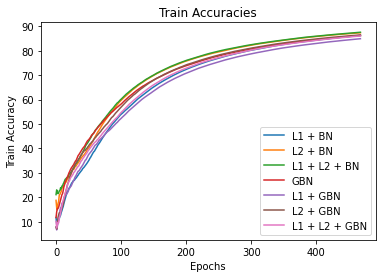

In [19]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["train_acc"][0],label=model_version)
  leg = ax.legend()
  
plt.title('Train Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

Text(0, 0.5, 'Validation Accuracy')

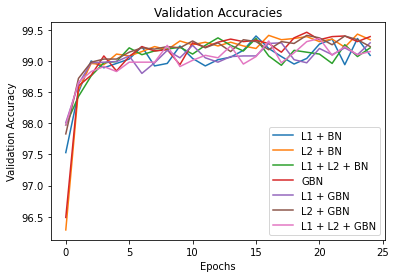

In [20]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["test_acc"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

Text(0, 0.5, 'Validation Accuracy')

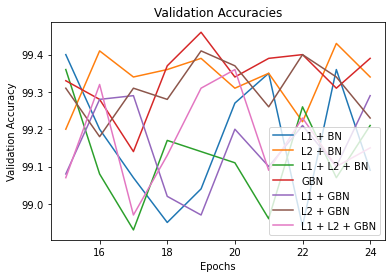

In [24]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  after15epochs_acc = model_history[model_number]["test_acc"][15:]
  ax.plot([x for x in range(15,25)],after15epochs_acc,label=model_version)
  # ax.plot(model_history[model_number]["test_acc"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

# plt.savefig(f'{root_path}/validation_accuracy_plot_after15epochs.png')

## Interactive Plots

In [ ]:
!pip install plotly
!pip install notebook ipywidgets

In [41]:
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [134]:
# color=["white","red", "blue", "green", "yellow", "gray", "black", "orange"]
# print(color[1])
# for model_number, model_version in model_versions.items():
#   if model_number > 4:
#     after15epochs_acc = model_history[model_number]["test_acc"][15:]
#     # print(model_history[model_number]["test_acc"][15:])
#     # print([x[0] for x in after15epochs_acc])

#     fig1 = make_subplots(rows=1, cols=1)
#     fig1.add_trace(go.Scatter(x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc]),row=1, col=1)
#     # fig1.add_trace(go.Scatter(name=model_version,x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc],mode='markers+lines',marker=dict(color='blue', size=2),showlegend=True))
#     fig1.add_trace(go.Scatter(name=model_version,x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
#     fig1.update_layout(height=600, width=800, title_text="Side By Side Subplots")

# fig1.show()

In [132]:
fig1 = make_subplots(rows=1, cols=1)
# fig1.add_trace(go.Scatter(x=[x for x in range(15,25)], y = [x[0] for x in model_history[1]["test_acc"][:]]),row=1, col=1)
model_number=1;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=2;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=3;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=4;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=5;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=6;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=7;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))

fig1.update_layout(height=600, width=800, title_text="Validation Accuracies")
fig1.update_xaxes(title_text="Epochs", row=1, col=1)
fig1.update_yaxes(title_text="Validation Accuracy", row=1, col=1)
fig1.show()

In [133]:
fig1 = make_subplots(rows=1, cols=1)
model_number=1;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=2;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=3;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=4;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=5;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=6;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=7;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))

fig1.update_layout(height=600, width=800, title_text="Validation Accuracies")
fig1.update_xaxes(title_text="Epochs", row=1, col=1)
fig1.update_yaxes(title_text="Validation Accuracy", row=1, col=1)
fig1.show()